In [1]:
import torch
from torch import zeros
torch.set_default_dtype(torch.float64)
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import pyro
pyro.enable_validation(True)

## Load behavioral data

In [2]:
df_res = pd.read_csv('pilot/responses.csv').set_index('subject')
responses = df_res.values[:, :-2].T.astype(float)

outcomes = pd.read_csv('pilot/outcomes.csv').set_index('subject').values.T.astype(float)
outcomes[np.nan_to_num(outcomes) < 2] = (outcomes[np.nan_to_num(outcomes) < 2] + 1)/2
outcomes[np.isnan(outcomes)] = 0.
corrects = pd.read_csv('pilot/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('pilot/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

mask_all = torch.from_numpy(~np.isnan(responses)).unsqueeze(0)
responses_all = torch.from_numpy(np.nan_to_num(responses)).long().unsqueeze(0)
outcomes_all = torch.from_numpy(np.nan_to_num(outcomes)).long().unsqueeze(0)
offers_all = torch.zeros(responses_all.shape, dtype=torch.long)
corrects_all = torch.from_numpy(corrects).unsqueeze(0)

In [3]:
# split participants on groups and exclude non-explorers
expl_subs = torch.sum(torch.squeeze(responses_all == 2), 0) > -1
expl_sub_num = torch.arange(nsub)[expl_subs]
reg_subs = expl_sub_num[expl_sub_num < ns_reg]
irr_subs = expl_sub_num[expl_sub_num >= ns_reg]

mask_c1 = mask_all[..., reg_subs]
mask_c2 = mask_all[..., irr_subs]

responses_c1 = responses_all[..., reg_subs]
responses_c2 = responses_all[..., irr_subs]

offers_c1 = offers_all[..., reg_subs]
offers_c2 = offers_all[..., irr_subs]

outcomes_c1 = outcomes_all[..., reg_subs]
outcomes_c2 = outcomes_all[..., irr_subs]

corr_c1 = corrects_all[..., reg_subs]
corr_c2 = corrects_all[..., irr_subs]

In [4]:
from stats import trials_until_correct, running_mean, performance

data = io.loadmat('pilot/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]
Sirr = torch.from_numpy(Sirr)
Oirr = torch.from_numpy(Oirr)
Sreg = torch.from_numpy(Sreg)
Oreg = torch.from_numpy(Oreg)

def plot_ppc(values, data, ax):
    perc = np.percentile(values, [5, 50, 95], axis=0)
    ax.errorbar(data, perc[1], yerr=np.diff(perc, axis=0), color='r', linestyle='', marker='o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=2)

def define_agents_and_environment(agent, pars, O, S, fixed_params=None):
    
    agents = []
    tasks = []
    
    for par, obs, states in zip(pars, O, S):
        T = len(states)
        vals = torch.from_numpy(par).reshape(-1, par.shape[-1])
        agents.append(agent(runs=vals.shape[0], trials=T))
        if fixed_params is not None:
            agents[-1].set_parameters()
            fixed = fixed_params['labels']
            free = list(set(range(agents[-1].npar)) - set(fixed))
            x = torch.zeros(vals.shape[:-1] + (agents[-1].npar,))
            x[..., free] = vals
        else:
            x = vals
        
        agents[-1].set_parameters(x)
        
        rewards = torch.cat([obs[None, :, :], states[None, :, None] + 2], -1)
        offers = zeros(1, T, 1, dtype=torch.long)
        
        runs = vals.shape[0]
        
        stimuli = {'states': states.reshape(1, T, 1), 
                   'rewards': rewards[..., None, :].repeat(1, 1, runs, 1), 
                   'offers': offers}
        
        tasks.append(TempRevLearn(stimuli=stimuli))

    return agents, tasks

ws = 201
tuc_data = trials_until_correct(np.nan_to_num(corr_c1[0].numpy()).T, Sreg[None].numpy(), τ=3)
rolling_tuc_data_c1 = running_mean(tuc_data, ws=ws)
rolling_perf_data_c1 = performance(np.nan_to_num(corr_c1[0].numpy()), ws=ws)

tuc_data = trials_until_correct(np.nan_to_num(corr_c2[0].numpy()).T, Sirr[None].numpy(), τ=3)
rolling_tuc_data_c2 = running_mean(tuc_data, ws=ws)
rolling_perf_data_c2 = performance(np.nan_to_num(corr_c2[0].numpy()), ws=ws)

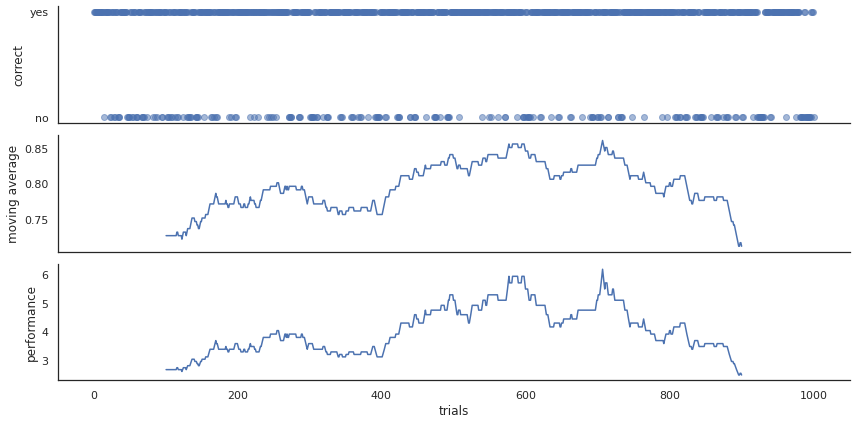

In [5]:
# performance
sub = 0

cor_sub = np.nan_to_num(corr_c1[0].numpy()).T[sub:sub+1]
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
trials = np.arange(1, 1001)
axes[0].plot(trials, cor_sub.T, 'bo', alpha=.5);
perc_corr = running_mean(cor_sub, ws=ws)[0]
axes[1].plot(trials[100:-100], perc_corr);
axes[2].plot(trials[100:-100], perc_corr/(1 - perc_corr))

axes[0].set_yticks([1, 0])
axes[0].set_yticklabels(['yes', 'no'])
axes[0].set_ylabel('correct');
axes[1].set_ylabel('moving average');
axes[2].set_ylabel('performance');
axes[2].set_xlabel('trials');

fig.tight_layout()
sns.despine(fig)
fig.savefig('example_performance.svg', transparent=True)

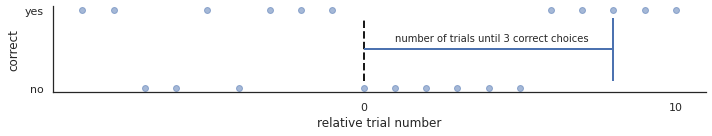

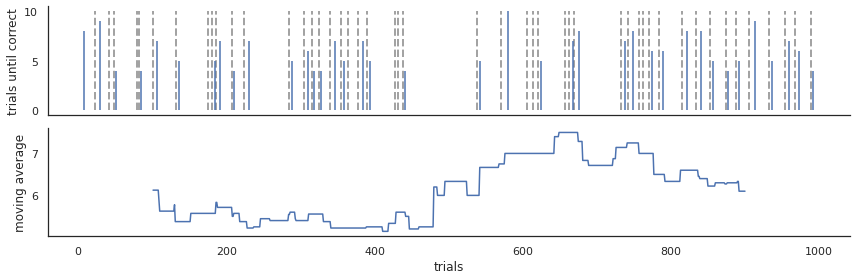

In [6]:
# trials until correct
sub = 0

switches = np.insert(np.abs(np.diff(Sirr.numpy(), axis=-1)), 0, 0, -1).astype(bool)

cor_sub = np.nan_to_num(corr_c2[0].numpy()).T[sub:sub+1]
fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharex=True, sharey=True)
trials = np.arange(1, 1001)
trial = trials[12:32][switches[12:32]]
axes.plot(trials[12:32] - trial, cor_sub.T[12:32], 'bo', alpha=.5);
axes.vlines(0, 0.1, .9, 'k', lw=2, linestyle='--')
axes.vlines(8, .1, .9, lw=2)
axes.hlines(.5, 0, 8, lw=2)
perc_corr = running_mean(cor_sub, ws=ws)[0]
axes.set_yticks([1, 0])
axes.set_yticklabels(['yes', 'no'])
axes.set_ylabel('correct');
axes.set_xlabel('relative trial number')
axes.set_xticks([0, 10])
axes.text(1, .6, 'number of trials until 3 correct choices')
# axes

fig.tight_layout()
sns.despine(fig)

fig.savefig('definition_tuc.svg', transparent=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].vlines(trials[switches], 0, 10, 'k', linestyle='--', lw=2, alpha=.4);
tucs = ~np.isnan(tuc_data[sub])
axes[0].vlines(trials[tucs], 0, tuc_data[sub][tucs])

axes[1].plot(trials[100:-100], rolling_tuc_data_c2[sub])

axes[0].set_ylabel('trials until correct');
axes[1].set_ylabel('moving average');
axes[1].set_xlabel('trials');

fig.tight_layout()
sns.despine(fig)
fig.savefig('example_tuc.svg', transparent=True)

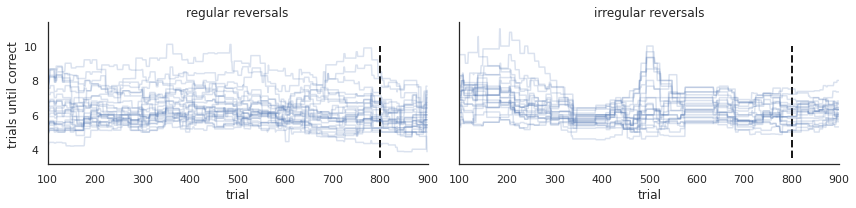

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey='all', sharex='all')

axes[0].plot(range(100, 900), rolling_tuc_data_c1.T, 'b', alpha=.2);
axes[1].plot(range(100, 900), rolling_tuc_data_c2.T, 'b', alpha=.2);
axes[0].set_title('regular reversals');
axes[1].set_title('irregular reversals');
axes[0].set_ylabel('trials until correct')
axes[0].set_xlabel('trial')
axes[1].set_xlabel('trial')
axes[0].set_xlim([100, 900])

axes[0].vlines(800, 3.5, 10, 'k', lw=2, linestyle='--')
axes[1].vlines(800, 3.5, 10, 'k', lw=2, linestyle='--')

fig.tight_layout()
sns.despine(fig)
fig.savefig('data_tuc.svg', transparent=True)

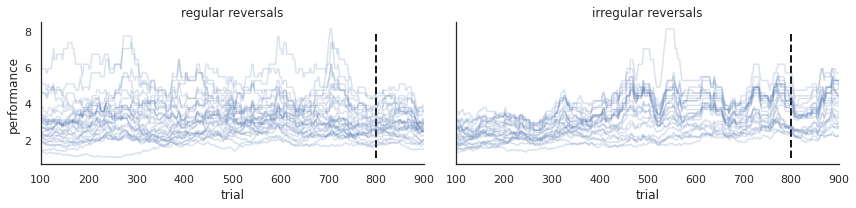

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey='all', sharex='all')

axes[0].plot(range(100, 900), rolling_perf_data_c1.T, 'b', alpha=.2);
axes[1].plot(range(100, 900), rolling_perf_data_c2.T, 'b', alpha=.2);
axes[0].set_title('regular reversals');
axes[1].set_title('irregular reversals');
axes[0].set_ylabel('performance')
axes[0].set_xlabel('trial')
axes[1].set_xlabel('trial')
axes[0].set_xlim([100, 900])

axes[0].vlines(800, 1, 8, 'k', lw=2, linestyle='--')
axes[1].vlines(800, 1, 8, 'k', lw=2, linestyle='--')

fig.tight_layout()
sns.despine(fig)
fig.savefig('data_performance.svg', transparent=True)

## Fit behavioural models

In [5]:
from befit.agents import RLTempRevLearn, ExplicitHMM
from befit.inference import NormalGammaHierarch

from befit.tasks import TempRevLearn
from befit.simulate import Simulator

In [6]:
# perform sequential parameter estimate and model selection
trials = 450

rl_agent_all = RLTempRevLearn(runs=responses_all.shape[-1], trials=trials)
rl_agent_all.set_parameters()

ps_rl_all = []
for i in [7]:
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_all[:, T1:T2].clone()
    offers = offers_all[:, T1:T2].clone()
    outcomes = outcomes_all[:, T1:T2].clone()
    responses = responses_all[:, T1:T2].clone()
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = NormalGammaHierarch(rl_agent_all, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=2000, num_particles=100)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_all.append(rl_infer.sample_posterior(labels, num_samples=1000))

Mean ELBO 7823.73: 100%|██████████| 2000/2000 [53:47<00:00,  1.61s/it]


In [8]:
pars_rl_c1 = ps_rl_all[0][0].loc[:, :'theta'].values.reshape(1000, -1, 4)[..., :ns_reg, :]
pars_rl_c2 = ps_rl_all[0][0].loc[:, :'theta'].values.reshape(1000, -1, 4)[..., ns_reg:, :]
num_samples = pars_rl_c1.shape[0]

start = 350

agents, tasks = define_agents_and_environment(RLTempRevLearn, 
                                              [pars_rl_c1, pars_rl_c2], 
                                              [(Oreg[start:] + 1)//2, (Oirr[start:] + 1)//2], 
                                              [Sreg[start:], Sirr[start:]])

sim = Simulator(tasks, agents, trials=1000 - start)
sim.simulate_experiment()
stimuli, responses = sim.format_stimuli_and_responses()

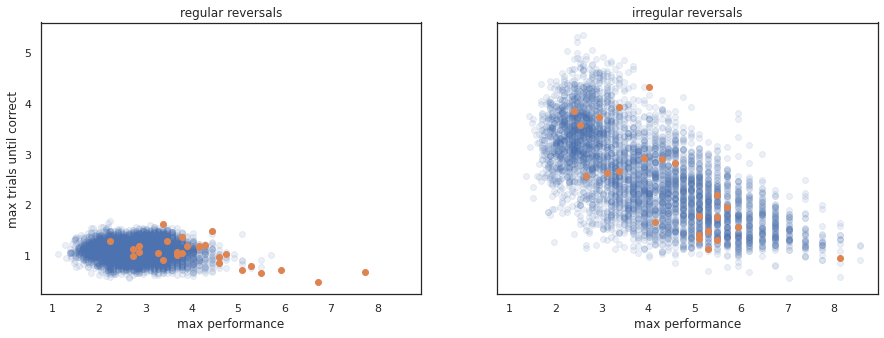

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

end = -200

axes[0].scatter(rolling_perf_rl_c1[::5, :, :end].max(-1), rolling_tuc_rl_c1[::5, :, :end].max(-1), alpha=0.1)
axes[0].scatter(rolling_perf_data_c1[...,start:end].max(-1), rolling_tuc_data_c1[..., start:end].max(-1))
axes[0].set_title('regular reversals');
axes[0].set_ylabel('max trials until correct');
axes[0].set_xlabel('max performance');

axes[1].scatter(rolling_perf_rl_c2[::5, :, :end].max(-1), rolling_tuc_rl_c2[::5, :, :end].max(-1), alpha=0.1)
axes[1].scatter(rolling_perf_data_c2[...,start:end].max(-1), rolling_tuc_data_c2[..., start:end].max(-1))

axes[1].set_title('irregular reversals');
axes[1].set_xlabel('max performance');

In [6]:
# perform sequential parameter estimate and model selection
trials = 250
iter_steps = 3000
num_samples = 20

edhmm_agent = ExplicitHMM(runs=responses_all.shape[-1], trials=trials)
edhmm_agent.set_parameters()

vals = zeros(responses_all.shape[-1], 1)
fixed_params = {
    'labels': [4],
    'values': vals
}

for i in [11]:
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_all[:, T1:T2].clone()
    offers = offers_all[:, T1:T2].clone()
    outcomes = outcomes_all[:, T1:T2].clone()
    responses = responses_all[:, T1:T2].clone()
    stimuli = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    
    edhmm_infer = NormalGammaHierarch(edhmm_agent, stimuli, responses, mask=mask, fixed_params=fixed_params)
    edhmm_infer.infer_posterior(iter_steps=iter_steps, num_particles=num_samples)

Mean ELBO 3832.61: 100%|██████████| 3000/3000 [15:05:44<00:00, 18.11s/it]  


In [7]:
labels = ['mu', 'phi', 'beta', 'lam', 'ph', 'pl', 'omega']
ps_edhmm = edhmm_infer.sample_posterior(labels, num_samples=10*num_samples)
#     me_edhmm_c1.append(edhmm_infer.get_log_evidence_per_subject(num_particles=200))

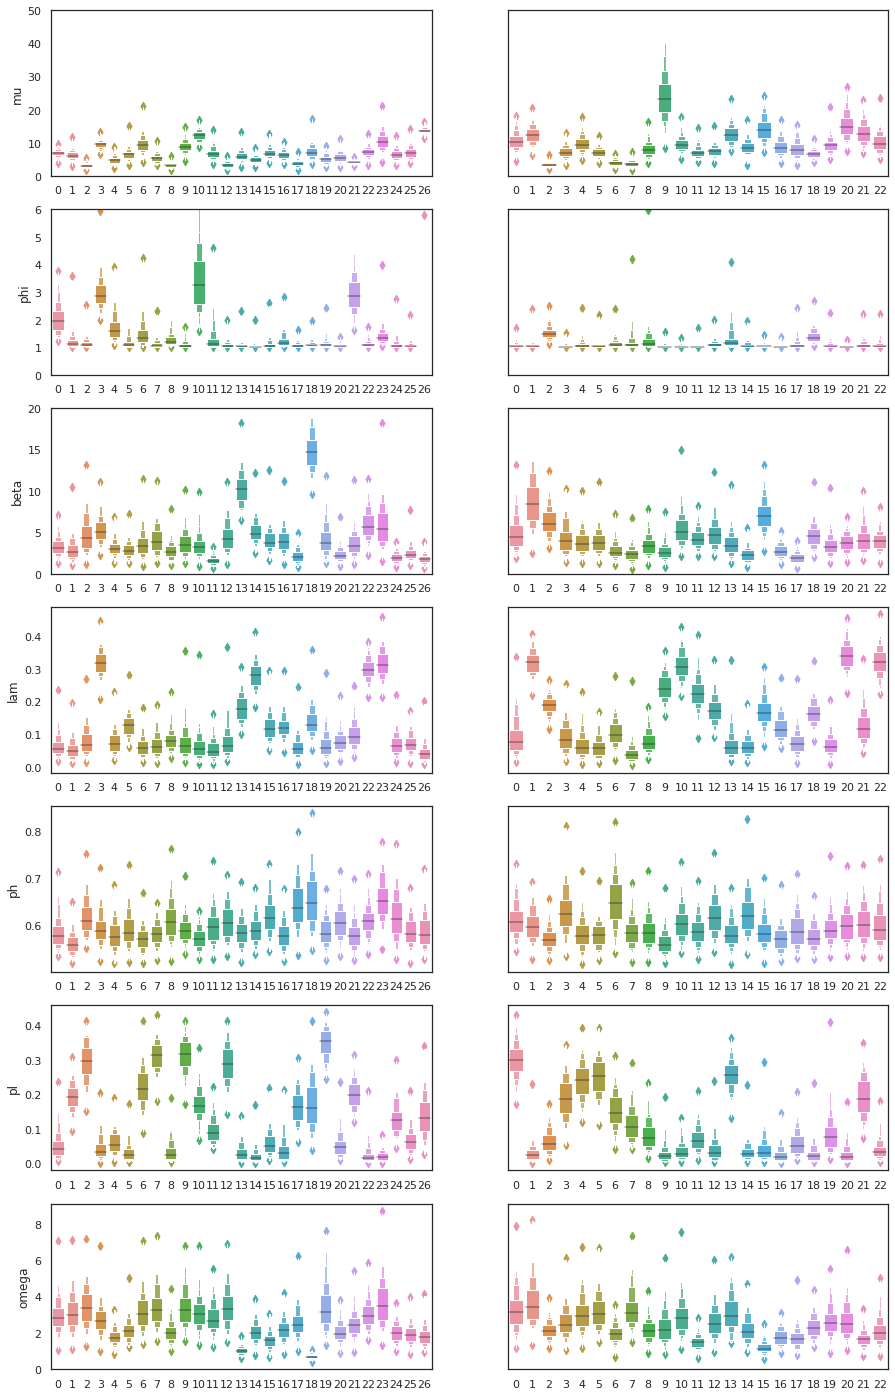

In [8]:
fig, axes = plt.subplots(7, 2, figsize=(15, 25), sharey='row')

for i, label in enumerate(labels):
    par_val1 = ps_edhmm[1][label].values.reshape(10 * num_samples, responses_all.shape[-1])[..., :ns_reg]
    par_val2 = ps_edhmm[1][label].values.reshape(10 * num_samples, responses_all.shape[-1])[..., ns_reg:]

    sns.boxenplot(data = par_val1, ax=axes[i, 0])
    sns.boxenplot(data = par_val2, ax=axes[i, 1])

    axes[i, 0].set_ylabel(label)
    if label== 'phi':
        axes[i, 0].set_ylim([0, 6])
        axes[i, 1].set_ylim([0, 6])
    if label== 'mu':
        axes[i, 0].set_ylim([0, 50])
        axes[i, 1].set_ylim([0, 50])
    if label == 'beta':
        axes[i, 0].set_ylim([0, 20])
        axes[i, 1].set_ylim([0, 20])


In [9]:
pars_all = ps_edhmm[0].loc[:, :'omega'].values.reshape(10 * num_samples, -1, 7)
np.savez('post_pars_edhmm_T600_800_allpars_omega.npz', all=pars_all)

In [19]:
# tmp = np.load('post_pars_edhmm_T450_allpars_omega.npz')
# tmp = np.load('post_pars_edhmm_T450.npz')
# tmp = np.load('post_pars_edhmm.npz')

In [10]:
tmp = np.load('post_pars_edhmm_T600_800_allpars_omega.npz')
vals = zeros(responses_all.shape[-1], 1)
fixed_params = {
    'labels': [4],
    'values': vals
}

In [11]:
pars_edhmm_c1 = tmp['all'][:, :ns_reg]
pars_edhmm_c2 = tmp['all'][:, ns_reg:]
num_samples = pars_edhmm_c1.shape[0]

start = 550

agents, tasks = define_agents_and_environment(ExplicitHMM, 
                                              [pars_edhmm_c1, pars_edhmm_c2], 
                                              [(1 + Oreg[start:])//2, (1 + Oirr[start:])//2], 
                                              [Sreg[start:], Sirr[start:]],
                                              fixed_params=fixed_params)

sim = Simulator(tasks, agents, trials=1000-start)
sim.simulate_experiment()
stimuli, responses = sim.format_stimuli_and_responses()

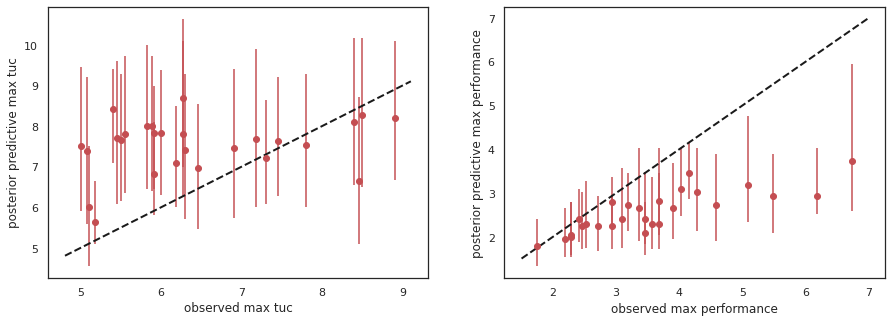

In [12]:
from stats import trials_until_correct, running_mean

start = 550
end = -200
ws = 201

states = Sreg[start:]
corrects = (responses['pair_0'] == states[None, :, None]).float()[0]
tuc = trials_until_correct(corrects.numpy().T, states[None].numpy(), τ=3)
rolling_tuc_c1 = running_mean(tuc, ws=ws).reshape(num_samples, pars_edhmm_c1.shape[-2], -1)
rolling_perf_c1 = performance(corrects.numpy(), ws=ws).reshape(num_samples, pars_edhmm_c1.shape[-2], -1)

max_rtuc_c1 = rolling_tuc_c1[..., :end].max(-1)
max_rperf_c1 = rolling_perf_c1[..., :end].max(-1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_ppc(max_rtuc_c1, rolling_tuc_data_c1[..., start:end].max(-1), axes[0])
axes[0].set_xlabel('observed max tuc');
axes[0].set_ylabel('posterior predictive max tuc');

plot_ppc(max_rperf_c1, rolling_perf_data_c1[..., start:end].max(-1), axes[1])
axes[1].set_xlabel('observed max performance');
axes[1].set_ylabel('posterior predictive max performance');

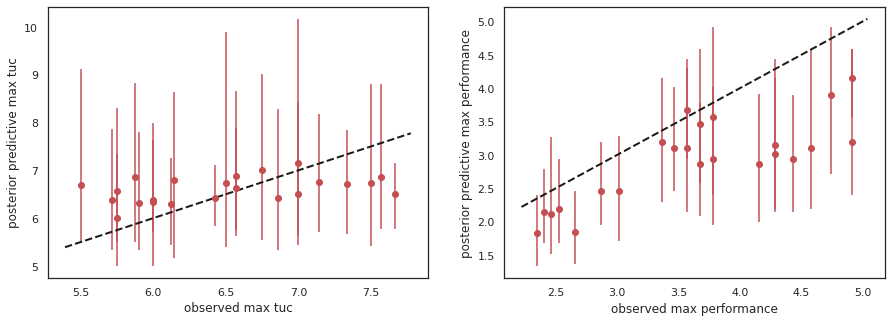

In [14]:
states = Sirr[start:]
corrects = (responses['pair_1'] == states[None, :, None]).float()[0]
tuc = trials_until_correct(corrects.numpy().T, states[None].numpy(), τ=3)
rolling_tuc_c2 = running_mean(tuc, ws=ws).reshape(num_samples, pars_edhmm_c2.shape[-2], -1)
rolling_perf_c2 = performance(corrects.numpy(), ws=ws).reshape(num_samples, pars_edhmm_c2.shape[-2], -1)

max_rtuc_c2 = rolling_tuc_c2[..., :end].max(-1)
max_rperf_c2 = rolling_perf_c2[..., :end].max(-1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_ppc(max_rtuc_c2, rolling_tuc_data_c2[..., start:end].max(-1), axes[0])
axes[0].set_xlabel('observed max tuc');
axes[0].set_ylabel('posterior predictive max tuc');

plot_ppc(max_rperf_c2, rolling_perf_data_c2[...,start:end].max(-1), axes[1])
axes[1].set_xlabel('observed max performance');
axes[1].set_ylabel('posterior predictive max performance');

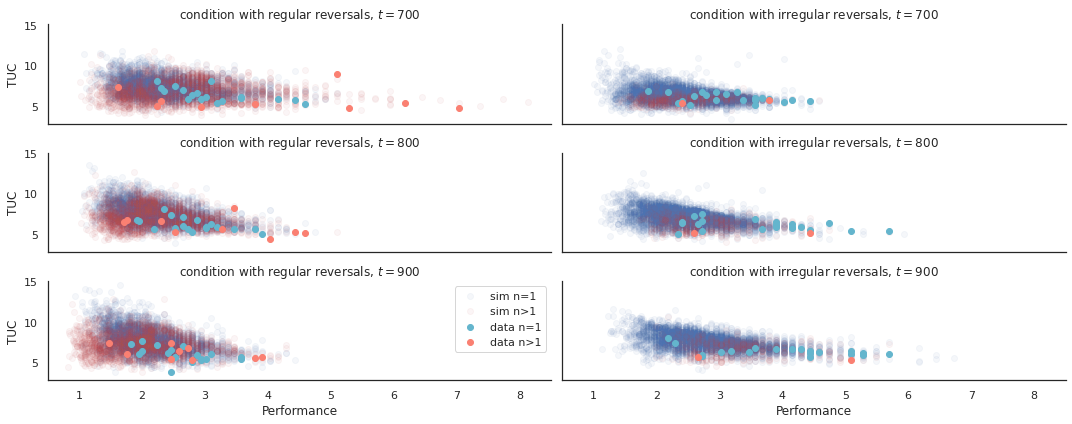

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(15, 6), sharex='all', sharey='all')

ns_c1 = corr_c1.shape[-1]
ns_c2 = corr_c2.shape[-1]

corr = [corr_c1, corr_c2]
S = [Sreg, Sirr]
count = [torch.sum(agents[0].phi.reshape(num_samples, ns_c1) > 1.1, 0),
        torch.sum(agents[1].phi.reshape(num_samples, ns_c2) > 1.1, 0)]
rolling_tuc = [rolling_tuc_c1, rolling_tuc_c2]
rolling_perf = [rolling_perf_c1, rolling_perf_c2]
rolling_tuc_data = [rolling_tuc_data_c1, rolling_tuc_data_c2]
rolling_perf_data = [rolling_perf_data_c1, rolling_perf_data_c2]
t1 = -200
threshold = 140
for i, ax in enumerate(axes[0]):
    regs = count[i] > threshold
    
    ax.scatter(rolling_perf[i][..., t1][:, ~regs],
               rolling_tuc[i][..., t1][:, ~regs], 
               color='b', alpha=.05)
    
    ax.scatter(rolling_perf[i][..., t1][:, regs],
               rolling_tuc[i][..., t1][:, regs], 
               color='r', alpha=.05)
    
    ax.scatter(rolling_perf_data[i][..., t1][~regs], 
               rolling_tuc_data[i][..., t1][~regs], color='c')
    ax.scatter(rolling_perf_data[i][..., t1][regs], 
               rolling_tuc_data[i][..., t1][regs], color='salmon')

t2 = -100
for i, ax in enumerate(axes[1]):
    regs = count[i] > threshold
    
    ax.scatter(rolling_perf[i][..., t2][:, ~regs],
           rolling_tuc[i][..., t2][:, ~regs], 
           color='b', alpha=.05)

    ax.scatter(rolling_perf[i][..., t2][:, regs],
               rolling_tuc[i][..., t2][:, regs], 
               color='r', alpha=.05)
    
    ax.scatter(rolling_perf_data[i][..., t2][~regs], 
               rolling_tuc_data[i][..., t2][~regs], color='c', label='post IRR')
    ax.scatter(rolling_perf_data[i][..., t2][regs], 
               rolling_tuc_data[i][..., t2][regs], color='salmon', label='post REG')
    

t3 = -1
for i, ax in enumerate(axes[2]):
    regs = count[i] > threshold
    
    ax.scatter(rolling_perf[i][..., t3][:, ~regs],
           rolling_tuc[i][..., t3][:, ~regs], 
           color='b', alpha=.05, label='sim n=1')

    ax.scatter(rolling_perf[i][..., t3][:, regs],
               rolling_tuc[i][..., t3][:, regs], 
               color='r', alpha=.05, label='sim n>1')
    
    ax.scatter(rolling_perf_data[i][..., t3][~regs], 
               rolling_tuc_data[i][..., t3][~regs], color='c', label='data n=1')
    ax.scatter(rolling_perf_data[i][..., t3][regs], 
               rolling_tuc_data[i][..., t3][regs], color='salmon', label='data n>1')

axes[0, 0].set_ylabel('TUC');
axes[1, 0].set_ylabel('TUC');
axes[2, 0].set_ylabel('TUC');
axes[2, 0].set_xlabel('Performance');
axes[2, 1].set_xlabel('Performance');

axes[2, 0].legend()

axes[0, 0].set_title('condition with regular reversals, $t = 700$');
axes[1, 0].set_title('condition with regular reversals, $t = 800$');
axes[2, 0].set_title('condition with regular reversals, $t = 900$');
axes[0, 1].set_title('condition with irregular reversals, $t = 700$');
axes[1, 1].set_title('condition with irregular reversals, $t = 800$');
axes[2, 1].set_title('condition with irregular reversals, $t = 900$');
axes[2, 0].set_xlim([.5, 8.5])

fig.tight_layout()
sns.despine(fig)
fig.savefig('max_perf_tuc_comp.svg', transparent=True)